# 제목

## #01. 패키지 준비하기

In [1]:
import sys
sys.path.append('../../')
import helper

from pandas import read_excel, DataFrame, merge
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

## #02. 데이터셋 준비하기

In [2]:
origin = read_excel("https://data.hossam.kr/F02/fish2.xlsx")
origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   길이      56 non-null     float64
 1   높이      56 non-null     float64
 2   두께      56 non-null     float64
 3   무게      56 non-null     float64
dtypes: float64(4)
memory usage: 1.9 KB


## #03. 데이터 전처리

### 결측치 확인

> 이미 다른 예제에서 진행된 절차이므로 생략

## #04. 탐색적 데이터 분석

### 기본통계 확인

> 이미 다른 예제에서 진행된 절차이므로 생략

### 산점도 그래프와 추세선 확인

In [3]:
plt.rcParams["font.family"] = 'Malgun Gothic'
plt.rcParams["font.size"] = 16
plt.rcParams['axes.unicode_minus'] = False

d:\python\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 3000x3000 with 0 Axes>

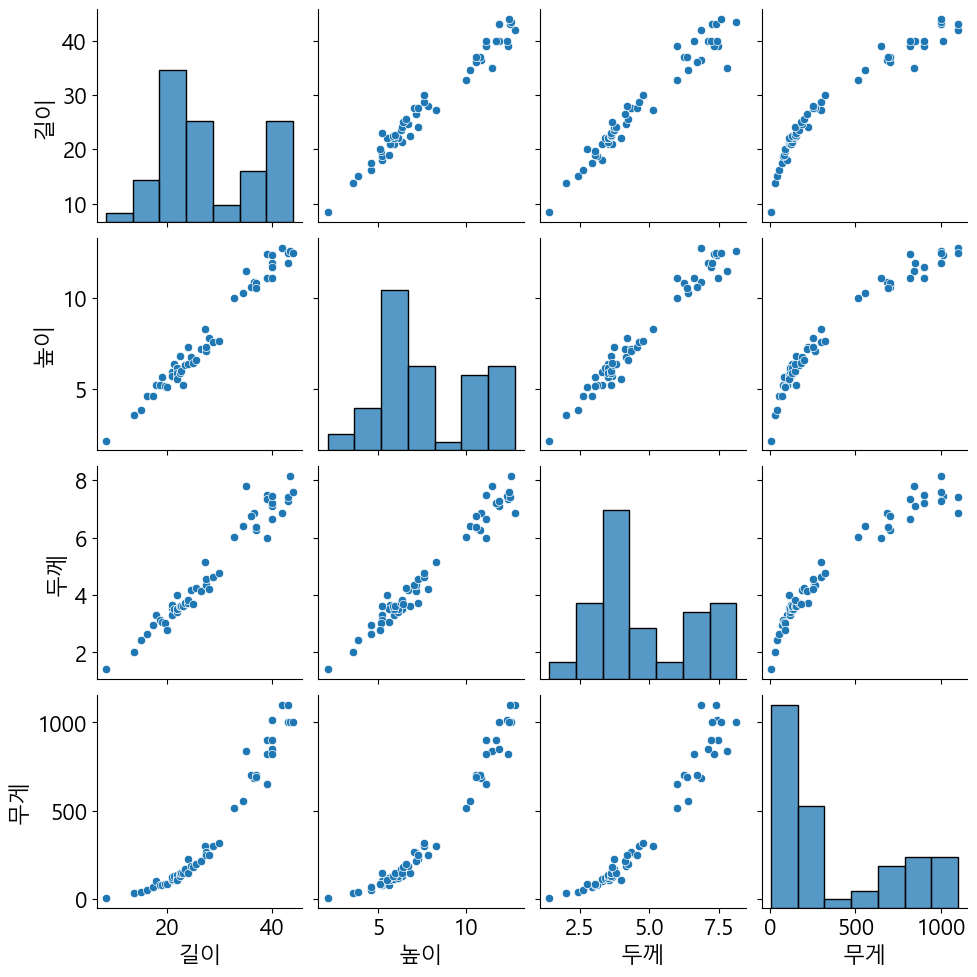

In [4]:
plt.figure(figsize=(30, 30))
sb.pairplot(origin)
plt.show()
plt.close()

> 산점도 그래프의 형태로 보아 다항식이 적합해 보임

## #05. 데이터셋 분할하기

### 랜덤시드 고정

In [5]:
np.random.seed(777)

### 훈련 데이터(독립변수)와 레이블(종속변수) 구분하기

In [6]:
x = origin[['길이','높이','두께']]
y = origin[['무게']]
x.shape, y.shape

((56, 3), (56, 1))

### 독립변수를 다항식으로 변환

In [7]:
poly = PolynomialFeatures(degree=2, include_bias=False)
fit = poly.fit_transform(x)
x2 = DataFrame(fit, columns=poly.get_feature_names_out())
x2.head()

,길이,높이,두께,길이^2,길이 높이,길이 두께,높이^2,높이 두께,두께^2
0,8.4,2.11,1.41,70.56,17.724,11.844,4.4521,2.9751,1.9881
1,13.7,3.53,2.00,187.69,48.361,27.400,12.4609,7.0600,4.0000
2,15.0,3.82,2.43,225.00,57.300,36.450,14.5924,9.2826,5.9049
3,16.2,4.59,2.63,262.44,74.358,42.606,21.0681,12.0717,6.9169
4,17.4,4.59,2.94,302.76,79.866,51.156,21.0681,13.4946,8.6436


### 데이터 표준화

In [8]:
x_scaller = StandardScaler()
x_scale = x_scaller.fit_transform(x2)

y_scaller = StandardScaler()
y_scale = y_scaller.fit_transform(y)

x_scale.shape, y_scale.shape

((56, 9), (56, 1))

### 훈련 데이터와 검증 데이터로 분할

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x_scale, y_scale, test_size=0.3, random_state=777)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((39, 9), (17, 9), (39, 1), (17, 1))

## #06. 모델 개발

### 모델 정의

In [10]:
model = Sequential()

# 1차원의 데이터를 입력으로 받고, 64개의 출력을 가지는 첫 번째 Dense 층
model.add(Dense(64, activation = 'relu', input_shape = (len(x_train[0]), )))
model.add(Dense(32, activation = 'relu'))

# 하나의 값을 출력 정답의 범위가 정해지지 않기 때문에 활성화 함수는 linear
model.add(Dense(1, activation = 'linear'))

model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                640       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2753 (10.75 KB)
Trainable params: 2753 (10.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 학습하기

In [11]:
result = model.fit(x_train, y_train, epochs=500, validation_data=(x_test, y_test), callbacks=[
    EarlyStopping(monitor='val_loss', patience=10, verbose=1),
    ReduceLROnPlateau(monitor= "val_loss", patience=3, factor = 0.5, min_lr=0.001, verbose=1)
])

Epoch 1/500
2/2 [==============================] - 1s 124ms/step - loss: 0.7953 - mae: 0.6855 - val_loss: 0.4701 - val_mae: 0.4888 - lr: 0.0010
Epoch 2/500
2/2 [==============================] - 0s 21ms/step - loss: 0.6300 - mae: 0.5759 - val_loss: 0.3496 - val_mae: 0.3870 - lr: 0.0010
Epoch 3/500
2/2 [==============================] - 0s 21ms/step - loss: 0.4932 - mae: 0.4770 - val_loss: 0.2597 - val_mae: 0.2985 - lr: 0.0010
Epoch 4/500
2/2 [==============================] - 0s 22ms/step - loss: 0.3719 - mae: 0.3950 - val_loss: 0.1906 - val_mae: 0.2505 - lr: 0.0010
Epoch 5/500
2/2 [==============================] - 0s 21ms/step - loss: 0.2979 - mae: 0.3471 - val_loss: 0.1345 - val_mae: 0.2223 - lr: 0.0010
Epoch 6/500
2/2 [==============================] - 0s 22ms/step - loss: 0.2216 - mae: 0.3011 - val_loss: 0.0894 - val_mae: 0.1811 - lr: 0.0010
Epoch 7/500
2/2 [==============================] - 0s 22ms/step - loss: 0.1575 - mae: 0.2527 - val_loss: 0.0549 - val_mae: 0.1331 - lr: 0.001

## #07. 학습 결과 평가

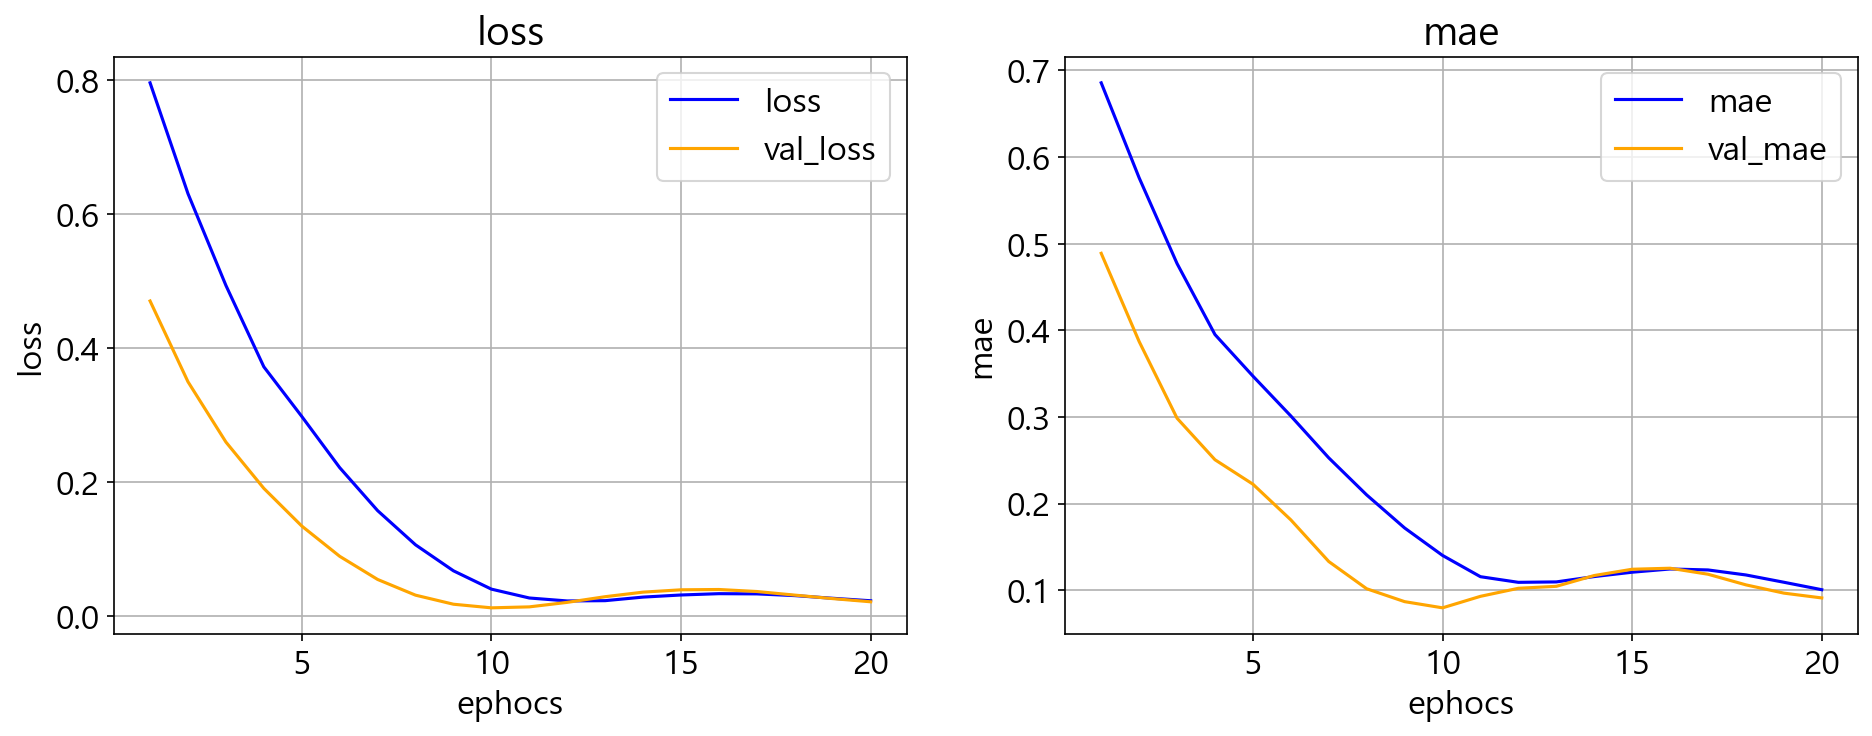

2/2 [==============================] - 0s 2ms/step - loss: 0.0210 - mae: 0.0968
최종 훈련 손실률: 0.021029, 최종 훈련 절대오차: 0.096775
1/1 [==============================] - 0s 17ms/step - loss: 0.0216 - mae: 0.0910
최종 검증 손실률: 0.021570, 최종 검증 절대오차: 0.091000


In [12]:
helper.tf_result_plot(result)

evaluate1 = model.evaluate(x_train, y_train)
print("최종 훈련 손실률: %f, 최종 훈련 절대오차: %f" % (evaluate1[0], evaluate1[1]))

evaluate2 = model.evaluate(x_test, y_test)
print("최종 검증 손실률: %f, 최종 검증 절대오차: %f" % (evaluate2[0], evaluate2[1]))

## #08. 학습 결과 적용

### 테스트 데이터에 대한 예측 결과 산정

In [13]:
train_pred = model.predict(x_train)
test_pred = model.predict(x_test)

1/1 [==============================] - 0s 14ms/step


### 결과 데이터 셋 구성

In [14]:
x2.columns

Index(['길이', '높이', '두께', '길이^2', '길이 높이', '길이 두께', '높이^2', '높이 두께', '두께^2'], dtype='object')

In [15]:
train_df = DataFrame(x_train, columns=x2.columns)
train_df['무게(관측치)'] = y_train.flatten()
train_df['무게(예측치)'] = train_pred.flatten()

train_df['훈련오차'] = train_df['무게(관측치)']-train_df['무게(예측치)']

train_df.head()

,길이,높이,두께,길이^2,길이 높이,길이 두께,높이^2,높이 두께,두께^2,무게(관측치),무게(예측치),훈련오차
0,-0.927534,-0.954292,-0.969558,-0.901344,-0.905194,-0.910571,-0.902581,-0.905521,-0.901350,-0.862814,-0.853507,-0.009307
1,-2.180225,-2.016507,-1.896175,-1.497943,-1.428186,-1.403939,-1.358064,-1.335908,-1.300665,-1.092422,-1.114634,0.022212
2,-0.659101,-0.779008,-0.696689,-0.711407,-0.758186,-0.726039,-0.790823,-0.761706,-0.728004,-0.761217,-0.755392,-0.005825
3,-0.368297,-0.396891,-0.327179,-0.480910,-0.496891,-0.466210,-0.511254,-0.482346,-0.452830,-0.563830,-0.527024,-0.036806
4,1.577847,1.731046,1.207709,1.723689,1.846825,1.455565,1.946749,1.554578,1.188140,2.083485,1.775825,0.307660


In [16]:
test_df = DataFrame(x_test, columns=x2.columns)
test_df['무게(관측치)'] = y_test.flatten()
test_df['무게(예측치)'] = test_pred.flatten()

test_df['훈련오차'] = test_df['무게(관측치)']-test_df['무게(예측치)']

test_df.head()

,길이,높이,두께,길이^2,길이 높이,길이 두께,높이^2,높이 두께,두께^2,무게(관측치),무게(예측치),훈련오차
0,-0.659101,-0.614242,-0.696689,-0.711407,-0.693048,-0.726039,-0.676317,-0.705421,-0.728004,-0.732189,-0.697494,-0.034695
1,-0.770948,-0.761480,-0.611417,-0.793211,-0.787101,-0.729863,-0.779077,-0.726681,-0.668631,-0.746703,-0.743325,-0.003378
2,-0.580807,-0.670333,-0.634156,-0.651880,-0.688985,-0.674770,-0.716326,-0.702314,-0.684706,-0.688648,-0.703636,0.014988
3,-0.043940,-0.204080,-0.099788,-0.193473,-0.278660,-0.227557,-0.351486,-0.305248,-0.260371,-0.383859,-0.337704,-0.046155
4,0.235678,-0.084887,0.013907,0.079999,-0.099752,-0.047479,-0.246445,-0.200537,-0.157535,-0.180666,-0.154807,-0.025859


### 실제 결과값과 머신러닝에 의한 예측값 비교

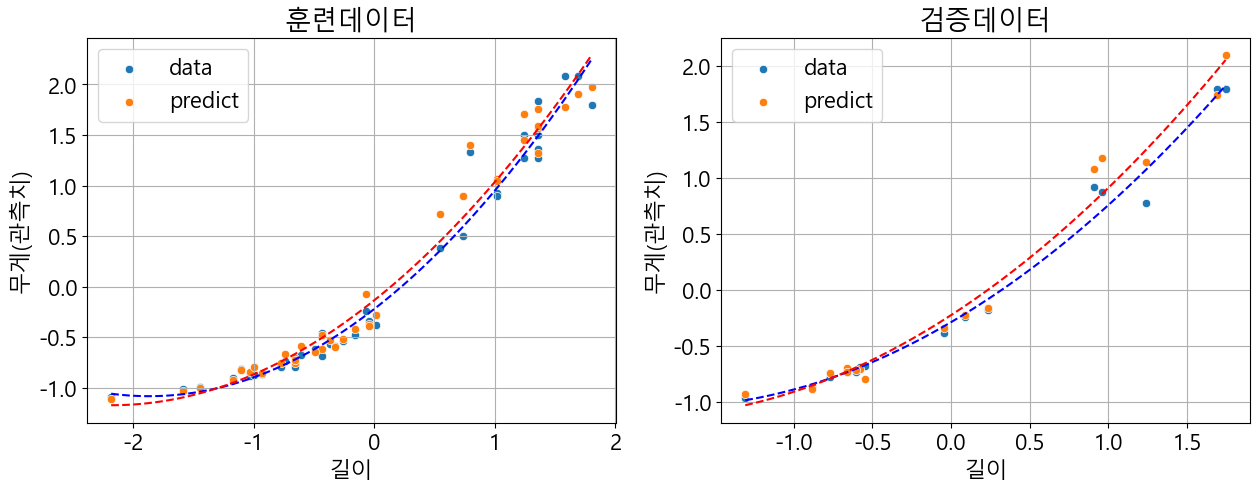

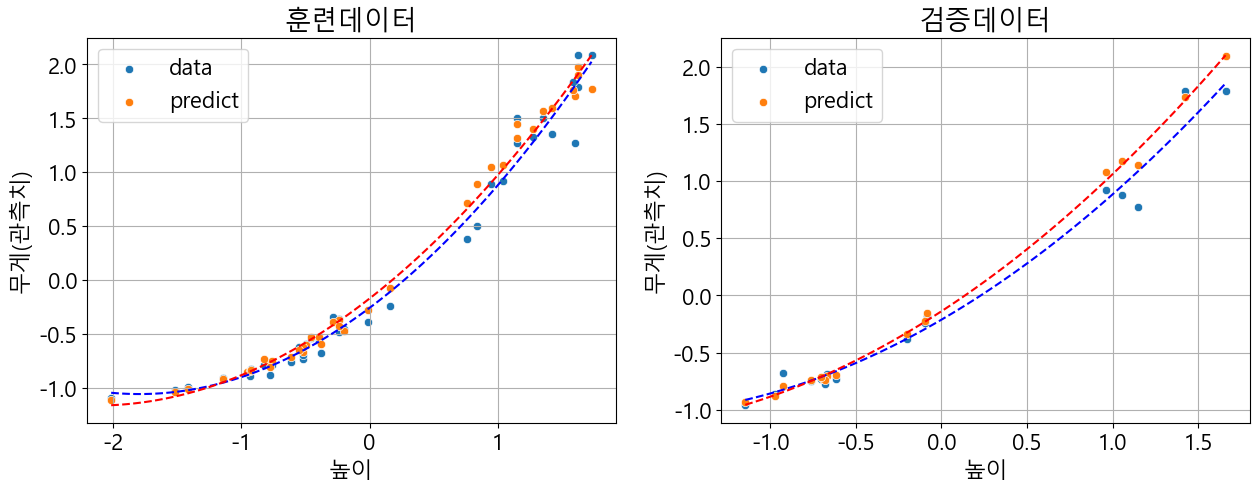

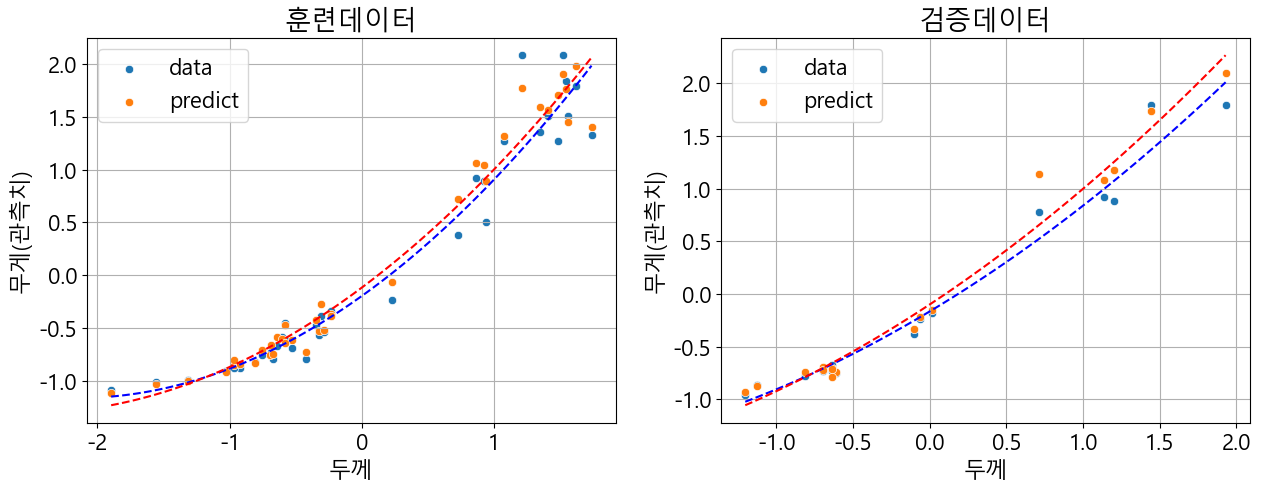

In [17]:
for key in ['길이','높이','두께']:
    helper.regplot(train_df[key], train_df['무게(관측치)'], train_df['무게(예측치)'], "훈련데이터",
                   test_df[key], test_df['무게(관측치)'], test_df['무게(예측치)'], "검증데이터",
                   figsize=(15, 5))